In [1]:
# Cell 1: Imports & Setup
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from glob import glob
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Cell 2: Dataset + DataLoader Creation (7 train cases, 3 test cases)

class BraTSSliceDataset(Dataset):
    def __init__(self, root_dir, indices):
        all_cases = sorted(os.listdir(root_dir))
        # select only the requested case folders
        chosen = [all_cases[i] for i in indices]
        self.data = []
        for case in chosen:
            case_path = os.path.join(root_dir, case)
            # match both .nii and .nii.gz
            flair_files = glob(os.path.join(case_path, "*flair.nii*"))
            seg_files   = glob(os.path.join(case_path, "*seg.nii*"))
            if not flair_files or not seg_files:
                print(f"Skipping {case}, missing flair/seg")
                continue
            flair = nib.load(flair_files[0]).get_fdata().astype(np.float32)
            seg   = nib.load(seg_files[0]).get_fdata().astype(np.uint8)
            # remap label 4→3
            seg[seg == 4] = 3
            # normalize flair
            flair = (flair - flair.min()) / (flair.max() - flair.min() + 1e-8)
            for z in range(flair.shape[2]):
                self.data.append((flair[:, :, z], seg[:, :, z]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, lbl = self.data[idx]
        img = torch.tensor(img[None, ...], dtype=torch.float32)  # 1×H×W
        lbl = torch.tensor(lbl, dtype=torch.long)                # H×W
        return img, lbl

# ---- Instantiate datasets ----
root = "/home/hiranmoy/Downloads/Sameer/Brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
# Determine valid cases automatically
all_cases = sorted(os.listdir(root))
valid = []
for i, case in enumerate(all_cases):
    cp = os.path.join(root, case)
    if glob(os.path.join(cp, "*flair.nii*")) and glob(os.path.join(cp, "*seg.nii*")):
        valid.append(i)

train_indices = valid[:7]
test_indices  = valid[7:10]

train_set = BraTSSliceDataset(root, train_indices)
test_set  = BraTSSliceDataset(root, test_indices)

# ---- Create DataLoaders ----
train_loader = DataLoader(train_set, batch_size=1, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

print("Train samples:", len(train_set), "→ batches:", len(train_loader))
print("Test  samples:", len(test_set),  "→ batches:", len(test_loader))


Train samples: 1085 → batches: 1085
Test  samples: 465 → batches: 465


In [3]:
# Cell 3: U-Net Definition & Quick Sanity Check

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, extra_conv=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.extra = extra_conv
        if extra_conv:
            self.conv3 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
            self.bn3   = nn.BatchNorm2d(out_ch)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        if self.extra:
            x = F.relu(self.bn3(self.conv3(x)))
        return x

class UNet(nn.Module):
    def __init__(self, depth=4, base_filters=64, skip_mode='concat', extra_conv=False):
        super().__init__()
        self.depth     = depth
        self.skip_mode = skip_mode
        # Encoder
        self.enc = nn.ModuleList()
        for d in range(depth):
            in_ch  = 1 if d==0 else base_filters*(2**(d-1))
            out_ch = base_filters*(2**d)
            self.enc.append(ConvBlock(in_ch, out_ch, extra_conv))
        self.pool = nn.MaxPool2d(2,2)
        # Bottleneck
        self.bottleneck = ConvBlock(base_filters*(2**(depth-1)), base_filters*(2**depth), extra_conv)
        # Decoder
        self.up  = nn.ModuleList()
        self.dec = nn.ModuleList()
        for d in reversed(range(depth)):
            in_ch  = base_filters*(2**(d+1))
            out_ch = base_filters*(2**d)
            self.up.append(nn.ConvTranspose2d(in_ch, out_ch, 2,2))
            blk_in = out_ch*2 if skip_mode=='concat' else out_ch
            self.dec.append(ConvBlock(blk_in, out_ch, extra_conv))
        # Classifier
        self.classifier = nn.Conv2d(base_filters, 4, 1)

    def forward(self, x):
        skips = []
        for enc in self.enc:
            x = enc(x) 
            skips.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        for up, dec, skip in zip(self.up, self.dec, reversed(skips)):
            x = up(x)
            if self.skip_mode=='concat':
                # crop if needed
                sh, sw = skip.shape[2:], x.shape[2:]
                if sh != sw:
                    dh, dw = (sh[0]-sw[0])//2, (sh[1]-sw[1])//2
                    skip = skip[:,:,dh:dh+sw[0], dw:dw+sw[1]]
                x = torch.cat([x, skip], dim=1)
            elif self.skip_mode=='sum':
                x = x + skip
            x = dec(x)
        return self.classifier(x)

# Quick check
unet = UNet(depth=4, base_filters=64, skip_mode='concat').to(device)
print("U-Net output:", unet(torch.randn(2,1,240,240,device=device)).shape)


U-Net output: torch.Size([2, 4, 240, 240])


In [4]:
# Cell 4: SegNet Definition & Quick Sanity Check

class SegNet(nn.Module):
    def __init__(self, depth=4, base_filters=64, extra_conv=False):
        super().__init__()
        self.depth = depth
        self.enc_blocks = nn.ModuleList()
        self.pool       = nn.ModuleList()
        in_ch = 1
        encoder_chs = []
        for d in range(depth):
            out_ch = base_filters*(2**d)
            self.enc_blocks.append(ConvBlock(in_ch, out_ch, extra_conv))
            self.pool.append(nn.MaxPool2d(2,2,return_indices=True))
            encoder_chs.append(out_ch)
            in_ch = out_ch
        self.bottleneck = ConvBlock(in_ch, in_ch, extra_conv)
        # Decoder uses encoder_chs reversed, reduced by one step:
        rev = list(reversed(encoder_chs))
        dec_outs = rev[1:] + [rev[-1]]
        self.unpool     = nn.ModuleList()
        self.dec_blocks = nn.ModuleList()
        in_ch = in_ch
        for out_ch in dec_outs:
            self.unpool.append(nn.MaxUnpool2d(2,2))
            self.dec_blocks.append(ConvBlock(in_ch, out_ch, extra_conv))
            in_ch = out_ch
        self.classifier = nn.Conv2d(in_ch, 4, 1)

    def forward(self, x):
        indices, sizes = [], []
        for enc, pool in zip(self.enc_blocks, self.pool):
            x = enc(x); sizes.append(x.size())
            x, ind = pool(x); indices.append(ind)
        x = self.bottleneck(x)
        for unp, dec, sz, ind in zip(self.unpool, self.dec_blocks, reversed(sizes), reversed(indices)):
            x = unp(x, ind, output_size=sz)
            x = dec(x)
        return self.classifier(x)

# Quick check
segnet = SegNet(depth=4, base_filters=64).to(device)
print("SegNet output:", segnet(torch.randn(2,1,240,240,device=device)).shape)


SegNet output: torch.Size([2, 4, 240, 240])


In [5]:
# Cell 5: MSU-Net Definition & Quick Sanity Check

class MSUBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv3 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(out_ch)
        self.conv5 = nn.Conv2d(in_ch, out_ch, 5, padding=2)
        self.bn5   = nn.BatchNorm2d(out_ch)
        self.merge = nn.Conv2d(out_ch*2, out_ch, 1)
        self.bnm   = nn.BatchNorm2d(out_ch)
    def forward(self, x):
        x3 = F.relu(self.bn3(self.conv3(x)))
        x5 = F.relu(self.bn5(self.conv5(x)))
        c  = torch.cat([x3, x5], dim=1)
        return F.relu(self.bnm(self.merge(c)))

class MSUNet(UNet):
    def __init__(self, depth=4, base_filters=64, skip_mode='concat', extra_conv=False):
        super().__init__(depth, base_filters, skip_mode, extra_conv)
        # swap encoder blocks
        for i in range(depth):
            in_ch  = 1 if i==0 else base_filters*(2**(i-1))
            out_ch = base_filters*(2**i)
            self.enc[i] = MSUBlock(in_ch, out_ch)
        # swap bottleneck
        self.bottleneck = MSUBlock(base_filters*(2**(depth-1)), base_filters*(2**depth))
        # swap decoder blocks
        for i in range(depth):
            out_ch = base_filters*(2**(depth-1-i))
            blk_in = out_ch* (2 if skip_mode=='concat' else 1)
            self.dec[i] = MSUBlock(blk_in, out_ch)

# Quick check
msunet = MSUNet(depth=4, base_filters=64, skip_mode='concat').to(device)
print("MSU-Net output:", msunet(torch.randn(2,1,240,240,device=device)).shape)


MSU-Net output: torch.Size([2, 4, 240, 240])


In [6]:
#6a Unet
# Metrics
def dice_coef(p, t, eps=1e-6):
    ds = []
    for c in range(1, 4):
        pc = (p == c).float(); tc = (t == c).float()
        ds.append((2 * (pc * tc).sum() + eps) / (pc.sum() + tc.sum() + eps))
    return sum(ds) / len(ds)

def iou_coef(p, t, eps=1e-6):
    is_ = []
    for c in range(1, 4):
        pc = (p == c).float(); tc = (t == c).float()
        inter = (pc * tc).sum(); uni = pc.sum() + tc.sum() - inter
        is_.append((inter + eps) / (uni + eps))
    return sum(is_) / len(is_)

# Common Configs
configs = [
  {'name':'Shallow','depth':3,'base_filters':64,'skip_mode':'concat','extra_conv':False},
  {'name':'Deep',   'depth':6,'base_filters':64,'skip_mode':'concat','extra_conv':False},
  {'name':'Wide',   'depth':4,'base_filters':128,'skip_mode':'concat','extra_conv':False},
  {'name':'Narrow', 'depth':4,'base_filters':16,'skip_mode':'concat','extra_conv':False},
  {'name':'SkipAdd','depth':4,'base_filters':64,'skip_mode':'sum','extra_conv':False},
  {'name':'SkipNone','depth':4,'base_filters':64,'skip_mode':'none','extra_conv':False},
  {'name':'Attention','depth':4,'base_filters':64,'skip_mode':'concat','extra_conv':False},
  {'name':'MultiScale','depth':4,'base_filters':64,'skip_mode':'concat','extra_conv':False},
  {'name':'Dilated','depth':4,'base_filters':64,'skip_mode':'concat','extra_conv':True},
  {'name':'ExtraConv','depth':4,'base_filters':64,'skip_mode':'concat','extra_conv':True}
]

def run_unet_experiments():
    print(f"\n>>> U-Net Experiments")
    results = []
    for cfg in configs:
        print(f"  * {cfg['name']}")
        model = UNet(depth=cfg['depth'], base_filters=cfg['base_filters'],
                     skip_mode=cfg['skip_mode'], extra_conv=cfg['extra_conv']).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss()

        model.train()
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            logits = model(imgs)
            if logits.shape[2:] != lbls.shape[1:]:
                th, tw = logits.shape[2:]
                ch, cw = (lbls.shape[1]-th)//2, (lbls.shape[2]-tw)//2
                lbls = lbls[:, ch:ch+th, cw:cw+tw]
            loss = loss_fn(logits, lbls)
            opt.zero_grad(); loss.backward(); opt.step()

        model.eval()
        dsum = isum = n = 0
        with torch.no_grad():
            for imgs, lbls in test_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                logits = model(imgs)
                preds = logits.argmax(1)
                if preds.shape[1:] != lbls.shape[1:]:
                    th, tw = preds.shape[1:]
                    ch, cw = (lbls.shape[1]-th)//2, (lbls.shape[2]-tw)//2
                    lbls = lbls[:, ch:ch+th, cw:cw+tw]
                dsum += dice_coef(preds, lbls).item()
                isum += iou_coef(preds, lbls).item()
                n += 1
        print(f"    Dice {dsum/n:.3f}, IoU {isum/n:.3f}")
        results.append((cfg['name'], dsum/n, isum/n))
    return results

res_unet = run_unet_experiments()
print("U-Net Results:", res_unet)



>>> U-Net Experiments
  * Shallow
    Dice 0.728, IoU 0.715
  * Deep
    Dice 0.729, IoU 0.720
  * Wide
    Dice 0.713, IoU 0.704
  * Narrow
    Dice 0.743, IoU 0.736
  * SkipAdd
    Dice 0.707, IoU 0.695
  * SkipNone
    Dice 0.734, IoU 0.734
  * Attention
    Dice 0.725, IoU 0.715
  * MultiScale
    Dice 0.727, IoU 0.716
  * Dilated
    Dice 0.745, IoU 0.735
  * ExtraConv
    Dice 0.732, IoU 0.722
U-Net Results: [('Shallow', 0.7277968766378375, 0.7152723907042732), ('Deep', 0.7289388322452818, 0.7198372549040557), ('Wide', 0.7125412316273798, 0.704218010171899), ('Narrow', 0.7429387974282118, 0.7357349701498337), ('SkipAdd', 0.7072831139679353, 0.6947624484767952), ('SkipNone', 0.7340501945281445, 0.7340501945281445), ('Attention', 0.7251898423689245, 0.7146894640159841), ('MultiScale', 0.7268457369728991, 0.7157653330632812), ('Dilated', 0.7453548527287401, 0.7354655390186979), ('ExtraConv', 0.7318638638140511, 0.722276646633402)]


In [7]:
#6b Segnet
def run_segnet_experiments():
    print(f"\n>>> SegNet Experiments")
    results = []
    for cfg in configs:
        print(f"  * {cfg['name']}")
        model = SegNet(depth=cfg['depth'], base_filters=cfg['base_filters'],
                       extra_conv=cfg['extra_conv']).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss()

        model.train()
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            logits = model(imgs)
            if logits.shape[2:] != lbls.shape[1:]:
                th, tw = logits.shape[2:]
                ch, cw = (lbls.shape[1]-th)//2, (lbls.shape[2]-tw)//2
                lbls = lbls[:, ch:ch+th, cw:cw+tw]
            loss = loss_fn(logits, lbls)
            opt.zero_grad(); loss.backward(); opt.step()

        model.eval()
        dsum = isum = n = 0
        with torch.no_grad():
            for imgs, lbls in test_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                logits = model(imgs)
                preds = logits.argmax(1)
                if preds.shape[1:] != lbls.shape[1:]:
                    th, tw = preds.shape[1:]
                    ch, cw = (lbls.shape[1]-th)//2, (lbls.shape[2]-tw)//2
                    lbls = lbls[:, ch:ch+th, cw:cw+tw]
                dsum += dice_coef(preds, lbls).item()
                isum += iou_coef(preds, lbls).item()
                n += 1
        print(f"    Dice {dsum/n:.3f}, IoU {isum/n:.3f}")
        results.append((cfg['name'], dsum/n, isum/n))
    return results

res_seg = run_segnet_experiments()
print("SegNet Results:", res_seg)



>>> SegNet Experiments
  * Shallow
    Dice 0.733, IoU 0.724
  * Deep
    Dice 0.725, IoU 0.714
  * Wide
    Dice 0.658, IoU 0.643
  * Narrow
    Dice 0.684, IoU 0.670
  * SkipAdd
    Dice 0.726, IoU 0.719
  * SkipNone
    Dice 0.731, IoU 0.719
  * Attention
    Dice 0.749, IoU 0.740
  * MultiScale
    Dice 0.721, IoU 0.710
  * Dilated
    Dice 0.682, IoU 0.667
  * ExtraConv
    Dice 0.728, IoU 0.715
SegNet Results: [('Shallow', 0.7330644191549225, 0.7242170299023866), ('Deep', 0.7249478564301055, 0.7144203083651071), ('Wide', 0.6584186694554744, 0.6428400891522567), ('Narrow', 0.6837319335765372, 0.6698270027965414), ('SkipAdd', 0.7262454399297812, 0.719478740752816), ('SkipNone', 0.7307607668883355, 0.71863742525627), ('Attention', 0.7491099313506238, 0.7403199457056622), ('MultiScale', 0.7209766263467587, 0.7100868571494473), ('Dilated', 0.6822389595050324, 0.6667028074583379), ('ExtraConv', 0.7275634610685747, 0.7149318276334491)]


In [8]:
# 6c MSUNet
def run_msunet_experiments():
    print("\n>>> MSU-Net Experiments")
    results = []
    for cfg in configs:
        print(f"  * {cfg['name']}")
        try:
            model = MSUNet(
                depth=cfg['depth'],
                base_filters=cfg['base_filters'],
                skip_mode=cfg['skip_mode'],
                extra_conv=cfg['extra_conv']
            ).to(device)

            opt = torch.optim.Adam(model.parameters(), lr=1e-3)
            loss_fn = nn.CrossEntropyLoss()

            model.train()
            for imgs, lbls in train_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                logits = model(imgs)
                if logits.shape[2:] != lbls.shape[1:]:
                    th, tw = logits.shape[2:]
                    ch = (lbls.shape[1] - th) // 2
                    cw = (lbls.shape[2] - tw) // 2
                    lbls = lbls[:, ch:ch+th, cw:cw+tw]
                loss = loss_fn(logits, lbls)
                opt.zero_grad(); loss.backward(); opt.step()

            model.eval()
            dsum = isum = n = 0
            with torch.no_grad():
                for imgs, lbls in test_loader:
                    imgs, lbls = imgs.to(device), lbls.to(device)
                    logits = model(imgs)
                    preds = logits.argmax(1)
                    if preds.shape[1:] != lbls.shape[1:]:
                        th, tw = preds.shape[1:]
                        ch = (lbls.shape[1] - th) // 2
                        cw = (lbls.shape[2] - tw) // 2
                        lbls = lbls[:, ch:ch+th, cw:cw+tw]
                    dsum += dice_coef(preds, lbls).item()
                    isum += iou_coef(preds, lbls).item()
                    n += 1

            dice = dsum / n
            iou  = isum / n
            results.append((cfg['name'], dice, iou))
            print(f"    ✅ Dice {dice:.3f}, IoU {iou:.3f}")

        except RuntimeError as e:
            print(f"    ❌ Skipped due to OOM: {cfg['name']}")
            results.append((cfg['name'], None, None))

        # 🔃 Free up memory explicitly
        del model, opt, loss_fn
        torch.cuda.empty_cache()

    return results

# Run MSU-Net experiments
res_msu = run_msunet_experiments()
print("\nMSU-Net Results:")
for name, dice, iou in res_msu:
    if dice is None:
        print(f"{name:12}: Skipped (OOM)")
    else:
        print(f"{name:12}: Dice={dice:.3f}, IoU={iou:.3f}")



>>> MSU-Net Experiments
  * Shallow
    ✅ Dice 0.723, IoU 0.712
  * Deep
    ❌ Skipped due to OOM: Deep
  * Wide
    ✅ Dice 0.746, IoU 0.738
  * Narrow
    ✅ Dice 0.734, IoU 0.725
  * SkipAdd
    ✅ Dice 0.738, IoU 0.729
  * SkipNone
    ✅ Dice 0.734, IoU 0.734
  * Attention
    ✅ Dice 0.713, IoU 0.700
  * MultiScale
    ✅ Dice 0.726, IoU 0.712
  * Dilated
    ✅ Dice 0.743, IoU 0.733
  * ExtraConv
    ✅ Dice 0.674, IoU 0.659

MSU-Net Results:
Shallow     : Dice=0.723, IoU=0.712
Deep        : Skipped (OOM)
Wide        : Dice=0.746, IoU=0.738
Narrow      : Dice=0.734, IoU=0.725
SkipAdd     : Dice=0.738, IoU=0.729
SkipNone    : Dice=0.734, IoU=0.734
Attention   : Dice=0.713, IoU=0.700
MultiScale  : Dice=0.726, IoU=0.712
Dilated     : Dice=0.743, IoU=0.733
ExtraConv   : Dice=0.674, IoU=0.659


SSIM-based Bottleneck Diversity: 0.8799
Top redundant channels (by cosine similarity): [681 633 653]
Inactive Channels (var < 1e-05): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 

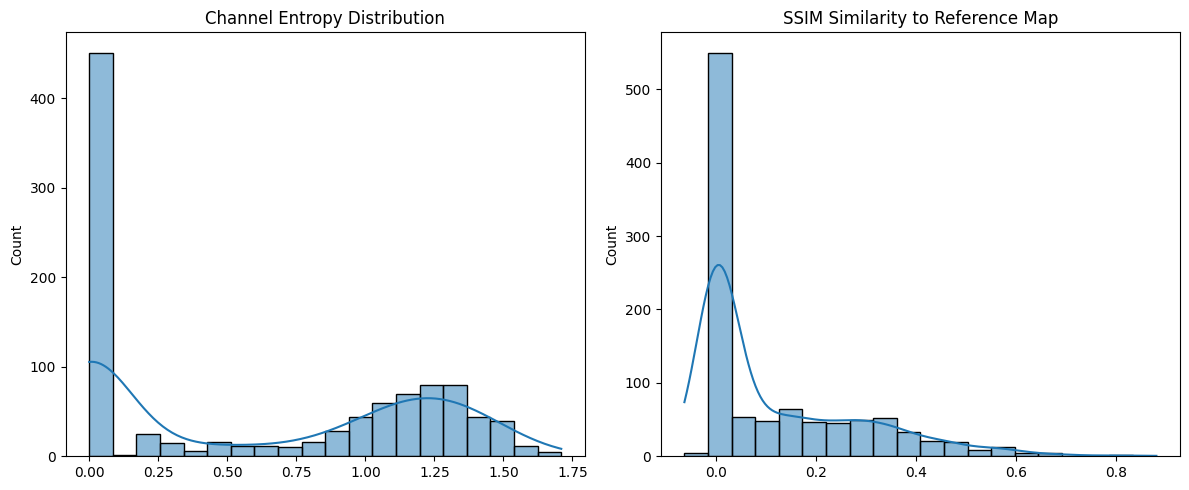

In [9]:
# Bottleneck Feature Analysis (SSIM, Entropy, Inactive Channels)
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
from scipy.stats import entropy
import pandas as pd

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- Utility: Capture Bottleneck Features ---
bottleneck_features = {}

def capture_bottleneck(module, input, output):
    bottleneck_features['feats'] = output.detach().cpu().squeeze(0)  # (C,H,W)

# --- Setup model and hook ---
model = UNet(depth=4, base_filters=64, skip_mode='concat').to(device)
model.eval()

# Register hook
hook = model.bottleneck.register_forward_hook(capture_bottleneck)

# Get one test image
sample_img, _ = next(iter(test_loader))
sample_img = sample_img.to(device)
_ = model(sample_img)

# Remove hook
hook.remove()

# Extract bottleneck features
feats = bottleneck_features['feats'].numpy()  # shape: (C, H, W)
C, H, W = feats.shape

# --- Compute SSIM Diversity ---
def compute_reference_map(features, top_k=3):
    C, H, W = features.shape
    flat = features.reshape(C, -1)
    sims = np.dot(flat, flat.T)
    norms = np.linalg.norm(flat, axis=1, keepdims=True)
    sims = sims / (norms * norms.T + 1e-8)
    r = sims.mean(axis=1)
    top_indices = np.argsort(r)[-top_k:]
    R = features[top_indices].mean(axis=0)
    return R, top_indices

R, top_k_idx = compute_reference_map(feats, top_k=3)
svals = [ssim(feats[i], R, data_range=R.max()-R.min()) for i in range(C)]
diversity = 1.0 - np.mean(svals)

print(f"SSIM-based Bottleneck Diversity: {diversity:.4f}")
print(f"Top redundant channels (by cosine similarity): {top_k_idx}")

# --- Compute Channel-wise Entropy ---
channel_entropies = [entropy(np.histogram(feats[i].flatten(), bins=32, range=(feats.min(), feats.max()), density=True)[0] + 1e-8)
                     for i in range(C)]

# --- Detect Inactive Channels (low variance) ---
variances = [np.var(feats[i]) for i in range(C)]
inactive_threshold = 1e-5  # adjustable threshold
inactive_channels = [i for i, var in enumerate(variances) if var < inactive_threshold]
print(f"Inactive Channels (var < {inactive_threshold}): {inactive_channels}")

# --- Save to CSV ---
df = pd.DataFrame({
    'Channel': np.arange(C),
    'SSIM_to_R': svals,
    'Entropy': channel_entropies,
    'Variance': variances,
    'IsInactive': [1 if i in inactive_channels else 0 for i in range(C)]
})
df.to_csv("unet_bottleneck_analysis.csv", index=False)
print("Saved metrics to 'unet_bottleneck_analysis.csv'")

# --- Visualization ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(channel_entropies, bins=20, kde=True)
plt.title("Channel Entropy Distribution")

plt.subplot(1,2,2)
sns.histplot(svals, bins=20, kde=True)
plt.title("SSIM Similarity to Reference Map")
plt.tight_layout()
plt.show()


In [10]:
#---------------------------------------------------------------------------------------------#

In [11]:
#---------------------------------------------------------------------------------------------#

In [12]:
# Cell 7 (updated): SSIM-Based Diversity Helper Functions with adaptive win_size

import numpy as np
from skimage.metrics import structural_similarity as ssim

def compute_reference_map(features, top_k=3):
    C, H, W = features.shape
    flat = features.reshape(C, -1)
    sims = flat @ flat.T
    norms = np.linalg.norm(flat, axis=1, keepdims=True)
    sims = sims / (norms * norms.T + 1e-8)
    redundancy = sims.mean(axis=1)
    top_idx = np.argsort(redundancy)[-top_k:]
    R = features[top_idx].mean(axis=0)
    return R.astype(np.float32), top_idx

def compute_diversity(features, top_k=3):
    """
    Compute diversity = 1 - mean(SSIM(channel_i, R)) using adaptive win_size.
    features: np.array of shape (C, H, W)
    """
    R, _ = compute_reference_map(features, top_k=top_k)
    C, H, W = features.shape
    # pick window size ≤ min(H,W), default 7
    max_win = min(7, H, W)
    # ensure odd
    if max_win % 2 == 0:
        max_win -= 1
    win_size = max_win if max_win >= 3 else max_win  # skimage needs ≥3
    dr = R.max() - R.min() + 1e-8

    svals = []
    for i in range(C):
        s = ssim(
            features[i],
            R,
            data_range=dr,
            win_size=win_size
        )
        svals.append(s)
    return 1.0 - float(np.mean(svals))


In [13]:
# Cell 8 (revised): Compute Bottleneck Diversity via Forward Hook

import torch

div_results = []
sample_img, _ = next(iter(test_loader))
sample_img = sample_img.to(device)

for cfg in configs:
    name = cfg['name']
    print(f"→ {name}", end=": ")

    # Instantiate and (optionally) load weights
    model = UNet(depth=cfg['depth'], base_filters=cfg['base_filters'],
                 skip_mode=cfg['skip_mode'], extra_conv=cfg['extra_conv']).to(device)
    # model.load_state_dict(torch.load(f"unet_{name}.pth"))  # if you have checkpoints

    # Prepare hook container
    feats = {}
    def bottleneck_hook(module, inp, outp):
        feats['bottleneck'] = outp

    # Register hook
    handle = model.bottleneck.register_forward_hook(bottleneck_hook)

    model.eval()
    with torch.no_grad():
        _ = model(sample_img)  # forward pass; hook saves bottleneck

    # Remove hook
    handle.remove()
    k = 3
    top_k = k
    # Extract and compute diversity
    bottleneck = feats['bottleneck'][0].cpu().numpy()  # shape (C, H, W)
    div = compute_diversity(bottleneck, top_k)
    print(f"{div:.3f}")
    div_results.append((name, div))

    # Cleanup
    del model, feats
    torch.cuda.empty_cache()

# Tabular summary
print("\nExperiment | Diversity")
for name, div in div_results:
    print(f"{name:10} | {div:.3f}")


→ Shallow: 0.753
→ Deep: 1.003
→ Wide: 0.910
→ Narrow: 0.903
→ SkipAdd: 0.885
→ SkipNone: 0.876
→ Attention: 0.901
→ MultiScale: 0.911
→ Dilated: 0.878
→ ExtraConv: 0.914

Experiment | Diversity
Shallow    | 0.753
Deep       | 1.003
Wide       | 0.910
Narrow     | 0.903
SkipAdd    | 0.885
SkipNone   | 0.876
Attention  | 0.901
MultiScale | 0.911
Dilated    | 0.878
ExtraConv  | 0.914


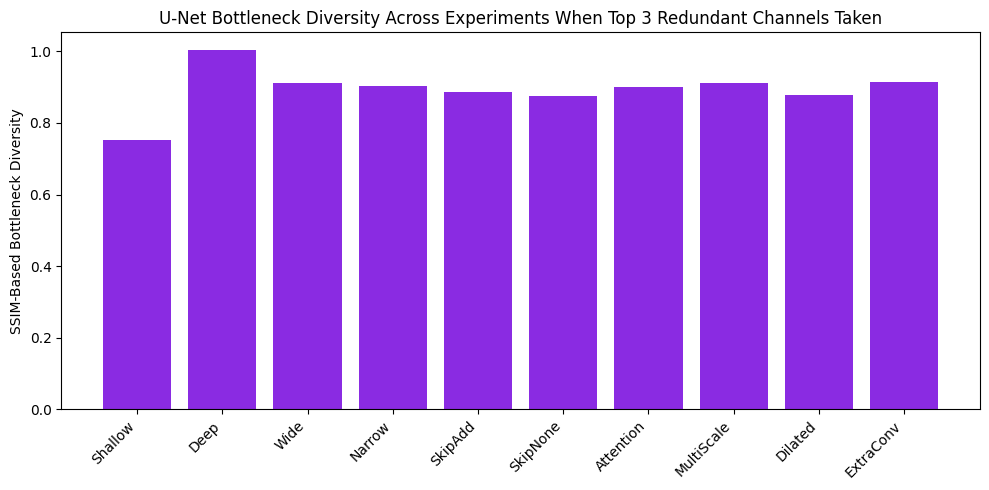

In [14]:
# Cell 9: Visualize Bottleneck Diversity Across Configurations

import matplotlib.pyplot as plt
import pandas as pd

df_div = pd.DataFrame(div_results, columns=['Experiment', 'Diversity'])

plt.figure(figsize=(10,5))
plt.bar(df_div['Experiment'], df_div['Diversity'], color='blueviolet')
plt.xticks(rotation=45, ha='right')
plt.ylabel('SSIM-Based Bottleneck Diversity')
plt.title(f'U-Net Bottleneck Diversity Across Experiments When Top {k} Redundant Channels Taken')
plt.tight_layout()
plt.show()


In [15]:
# Cell 8 (revised): Compute Bottleneck Diversity via Forward Hook

import torch

div_results = []
sample_img, _ = next(iter(test_loader))
sample_img = sample_img.to(device)

for cfg in configs:
    name = cfg['name']
    print(f"→ {name}", end=": ")

    # Instantiate and (optionally) load weights
    model = UNet(depth=cfg['depth'], base_filters=cfg['base_filters'],
                 skip_mode=cfg['skip_mode'], extra_conv=cfg['extra_conv']).to(device)
    # model.load_state_dict(torch.load(f"unet_{name}.pth"))  # if you have checkpoints

    # Prepare hook container
    feats = {}
    def bottleneck_hook(module, inp, outp):
        feats['bottleneck'] = outp

    # Register hook
    handle = model.bottleneck.register_forward_hook(bottleneck_hook)

    model.eval()
    with torch.no_grad():
        _ = model(sample_img)  # forward pass; hook saves bottleneck

    # Remove hook
    handle.remove()
    k = 5
    top_k = k
    # Extract and compute diversity
    bottleneck = feats['bottleneck'][0].cpu().numpy()  # shape (C, H, W)
    div = compute_diversity(bottleneck, top_k)
    print(f"{div:.3f}")
    div_results.append((name, div))

    # Cleanup
    del model, feats
    torch.cuda.empty_cache()

# Tabular summary
print("\nExperiment | Diversity")
for name, div in div_results:
    print(f"{name:10} | {div:.3f}")


→ Shallow: 0.764
→ Deep: 0.997
→ Wide: 0.909
→ Narrow: 0.877
→ SkipAdd: 0.891
→ SkipNone: 0.893
→ Attention: 0.879
→ MultiScale: 0.878
→ Dilated: 0.897
→ ExtraConv: 0.906

Experiment | Diversity
Shallow    | 0.764
Deep       | 0.997
Wide       | 0.909
Narrow     | 0.877
SkipAdd    | 0.891
SkipNone   | 0.893
Attention  | 0.879
MultiScale | 0.878
Dilated    | 0.897
ExtraConv  | 0.906


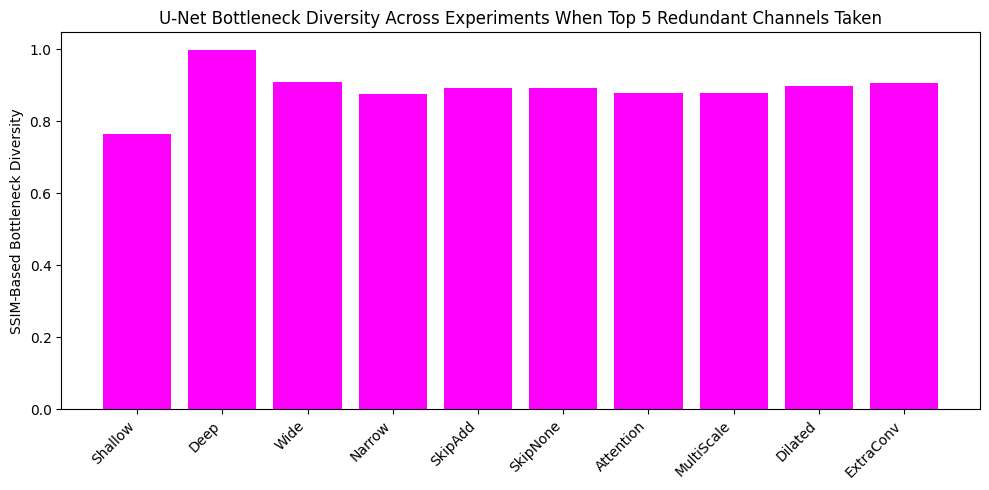

In [16]:
# Cell 9: Visualize Bottleneck Diversity Across Configurations

import matplotlib.pyplot as plt
import pandas as pd

df_div = pd.DataFrame(div_results, columns=['Experiment', 'Diversity'])

plt.figure(figsize=(10,5))
plt.bar(df_div['Experiment'], df_div['Diversity'], color='magenta')
plt.xticks(rotation=45, ha='right')
plt.ylabel('SSIM-Based Bottleneck Diversity')
plt.title(f'U-Net Bottleneck Diversity Across Experiments When Top {k} Redundant Channels Taken')
plt.tight_layout()
plt.show()


In [17]:
# Cell 10: Compute SegNet Bottleneck Diversity via Forward Hook

import torch

div_results_seg = []
sample_img, _ = next(iter(test_loader))
sample_img = sample_img.to(device)

for cfg in configs:
    name = cfg['name']
    print(f"→ {name}", end=": ")

    # Instantiate and (optionally) load SegNet weights
    model = SegNet(depth=cfg['depth'], base_filters=cfg['base_filters'],
                   extra_conv=cfg['extra_conv']).to(device)
    # model.load_state_dict(torch.load(f"segnet_{name}.pth"))  # if checkpoints exist

    # Hook to capture bottleneck
    feats = {}
    handle = model.bottleneck.register_forward_hook(lambda m, i, o: feats.setdefault('bottleneck', o))

    model.eval()
    with torch.no_grad():
        _ = model(sample_img)

    handle.remove()

    # Compute diversity
    bottleneck = feats['bottleneck'][0].cpu().numpy()  # (C, H, W)
    div = compute_diversity(bottleneck, top_k=3)
    print(f"{div:.3f}")
    div_results_seg.append((name, div))

    # Clean up
    del model, feats
    torch.cuda.empty_cache()

# Tabular summary
print("\nSegNet Experiment | Diversity")
for name, div in div_results_seg:
    print(f"{name:10} | {div:.3f}")


→ Shallow: 0.729
→ Deep: 0.996
→ Wide: 0.900
→ Narrow: 0.873
→ SkipAdd: 0.883
→ SkipNone: 0.883
→ Attention: 0.900
→ MultiScale: 0.870
→ Dilated: 0.864
→ ExtraConv: 0.879

SegNet Experiment | Diversity
Shallow    | 0.729
Deep       | 0.996
Wide       | 0.900
Narrow     | 0.873
SkipAdd    | 0.883
SkipNone   | 0.883
Attention  | 0.900
MultiScale | 0.870
Dilated    | 0.864
ExtraConv  | 0.879


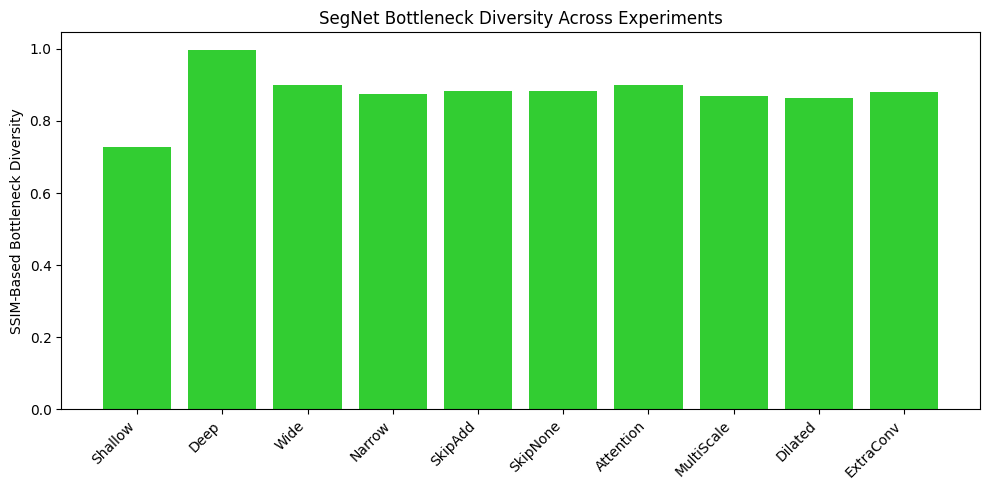

In [18]:
# Cell 11: Visualize SegNet Bottleneck Diversity

import matplotlib.pyplot as plt
import pandas as pd

df_seg_div = pd.DataFrame(div_results_seg, columns=['Experiment', 'Diversity'])

plt.figure(figsize=(10,5))
plt.bar(df_seg_div['Experiment'], df_seg_div['Diversity'], color='limegreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel('SSIM-Based Bottleneck Diversity')
plt.title('SegNet Bottleneck Diversity Across Experiments')
plt.tight_layout()
plt.show()


In [19]:
# Cell 10: Compute SegNet Bottleneck Diversity via Forward Hook

import torch

div_results_seg = []
sample_img, _ = next(iter(test_loader))
sample_img = sample_img.to(device)

for cfg in configs:
    name = cfg['name']
    print(f"→ {name}", end=": ")

    # Instantiate and (optionally) load SegNet weights
    model = SegNet(depth=cfg['depth'], base_filters=cfg['base_filters'],
                   extra_conv=cfg['extra_conv']).to(device)
    # model.load_state_dict(torch.load(f"segnet_{name}.pth"))  # if checkpoints exist

    # Hook to capture bottleneck
    feats = {}
    handle = model.bottleneck.register_forward_hook(lambda m, i, o: feats.setdefault('bottleneck', o))

    model.eval()
    with torch.no_grad():
        _ = model(sample_img)

    handle.remove()

    # Compute diversity
    bottleneck = feats['bottleneck'][0].cpu().numpy()  # (C, H, W)
    div = compute_diversity(bottleneck, top_k=5)
    print(f"{div:.3f}")
    div_results_seg.append((name, div))

    # Clean up
    del model, feats
    torch.cuda.empty_cache()

# Tabular summary
print("\nSegNet Experiment | Diversity")
for name, div in div_results_seg:
    print(f"{name:10} | {div:.3f}")


→ Shallow: 0.773
→ Deep: 1.000
→ Wide: 0.894
→ Narrow: 0.878
→ SkipAdd: 0.895
→ SkipNone: 0.877
→ Attention: 0.871
→ MultiScale: 0.869
→ Dilated: 0.892
→ ExtraConv: 0.885

SegNet Experiment | Diversity
Shallow    | 0.773
Deep       | 1.000
Wide       | 0.894
Narrow     | 0.878
SkipAdd    | 0.895
SkipNone   | 0.877
Attention  | 0.871
MultiScale | 0.869
Dilated    | 0.892
ExtraConv  | 0.885


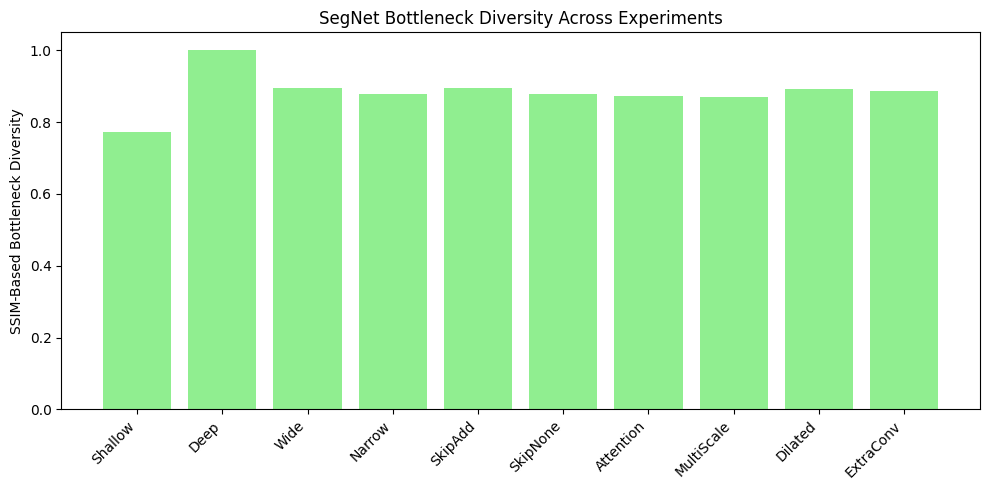

In [20]:
# Cell 11: Visualize SegNet Bottleneck Diversity

import matplotlib.pyplot as plt
import pandas as pd

df_seg_div = pd.DataFrame(div_results_seg, columns=['Experiment', 'Diversity'])

plt.figure(figsize=(10,5))
plt.bar(df_seg_div['Experiment'], df_seg_div['Diversity'], color='lightgreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel('SSIM-Based Bottleneck Diversity')
plt.title('SegNet Bottleneck Diversity Across Experiments')
plt.tight_layout()
plt.show()


In [21]:
# Cell X: Capture and Compute Bottleneck Channel Activations for UNET


import numpy as np
import torch

# 1) Set up the hook container
activations = {'abs_sum': None, 'count': 0}

# 2) Define the forward hook on the bottleneck
def bottleneck_hook(module, inp, out):
    # out: [B, C, H, W]
    abs_sum = out.abs().sum(dim=(0,2,3)).cpu().numpy()  # per-channel sum of |activation|
    count = out.numel() // out.shape[1]                  # B*H*W pixels per channel
    if activations['abs_sum'] is None:
        activations['abs_sum'] = abs_sum
    else:
        activations['abs_sum'] += abs_sum
    activations['count'] += count

# 3) Register hook on your model's bottleneck
unet = UNet(depth=4, base_filters=64, skip_mode='concat').to(device)
hook_handle = unet.bottleneck.register_forward_hook(bottleneck_hook)

# 4) Run through the test set
unet.eval()
with torch.no_grad():
    for imgs, _ in test_loader:
        _ = unet(imgs.to(device))

# 5) Remove hook
hook_handle.remove()

# 6) Compute mean activation per channel and identify inactive channels
abs_sum = activations['abs_sum']      # shape (C,)
count   = activations['count']        # scalar
mean_act = abs_sum / count            # mean |activation| per channel
threshold = 0.0009003875707242362 # choose a small epsilon for “inactive”
inactive_channels = np.where(mean_act < threshold)[0].tolist()


   Channel  MeanAbsActivation  Inactive
0        0           0.000319      True
1        1           0.010018     False
2        2           0.001451     False
3        3           0.008145     False
4        4           0.000000      True
5        5           0.000000      True
6        6           0.000017      True
7        7           0.005171     False
8        8           0.000000      True
9        9           0.000000      True


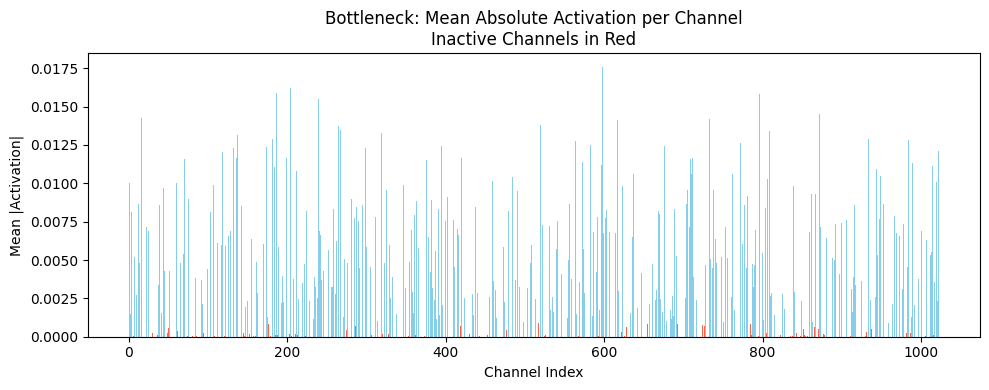

In [22]:
# Cell XY: Tabular & Visual Display of Bottleneck Activity (Local Version)

import pandas as pd
import matplotlib.pyplot as plt

# 1) Build DataFrame
df = pd.DataFrame({
    'Channel': np.arange(len(mean_act)),
    'MeanAbsActivation': mean_act,
    'Inactive': [ch in inactive_channels for ch in range(len(mean_act))]
})

# 2) Print first few rows and save to CSV if needed
print(df.head(10))
df.to_csv("bottleneck_channel_activity_new.csv", index=False)

# 3) Plot bar chart
plt.figure(figsize=(10, 4))
colors = ['tomato' if inact else 'skyblue' for inact in df['Inactive']]
plt.bar(df['Channel'], df['MeanAbsActivation'], color=colors)
plt.xlabel("Channel Index")
plt.ylabel("Mean |Activation|")
plt.title("Bottleneck: Mean Absolute Activation per Channel\nInactive Channels in Red")
plt.tight_layout()
plt.show()


In [23]:
import numpy as np

# Your list of values
data = [
    0.000100315399352225, 0.000101835508357952, 0.000105241818809737, 0.000105765111415047,
    0.000109644298485103, 0.000110393492266838, 0.000111742956236699, 0.000116127515494325,
    0.000116381400232532, 0.000118343120834733, 0.00011943606578321, 0.000122472683303815,
    0.000123035344314119, 0.000124618812843605, 0.00012679596129569, 0.00012695887667019,
    0.00013112232021391, 0.00013556961916396, 0.000135841898308575, 0.000139970248460485,
    0.000150512467433332, 0.000151236011135963, 0.000152741225959295, 0.000159929209427737,
    0.00016390710463803, 0.000170246976535665, 0.000177721868991282, 0.000180890045712926,
    0.000194851564250112, 0.000197113930395712, 0.000197185520915005, 0.000203916032396907,
    0.000205770330759502, 0.000211465650989163, 0.00021350509661785, 0.000215410658677989,
    0.000217454388435026, 0.000218211238956793, 0.000223367834603915, 0.000228971547408201,
    0.000235445084110383, 0.000242338556542619, 0.000245675983679622, 0.000252556804260473,
    0.000255333521032846, 0.000265460799386994, 0.000269284903504658, 0.000274791649165547,
    0.00028401215073598, 0.000288086502640336, 0.000314842962449597, 0.00031554774713915,
    0.000331664164006496, 0.000332200646258027, 0.000349655242518855, 0.000381179791339979,
    0.000381660999220617, 0.000395325545626587, 0.000405640961021505, 0.000429642762761817,
    0.00044829589406222, 0.000455472994021617, 0.00046560227771244, 0.000503657588252315,
    0.000519549954322077, 0.000521498558199391, 0.000522853290735607, 0.000566915532594086,
    0.000580603340905485, 0.00059019278796343, 0.000595474990607732, 0.000599295302816047,
    0.000603066648348828, 0.000615123680415547, 0.000620128563228047, 0.000644549407412074,
    0.000646826303133401, 0.000658027967956616, 0.00066085031525351, 0.00068104733702957,
    0.000688310593544654, 0.000700609578596363, 0.000702929206219198, 0.000772945937289987,
    0.000784902921286962, 0.000828232267281773, 0.000857471096900202, 0.000860564346951538,
    0.000862177366851478, 0.000876121384268593, 0.000891706642141764, 0.000895638341687201,
    0.000904983356434812, 0.000908582899305556, 0.000920549508918571, 0.000921808276979727,
    0.000935672372615181, 0.000944292913913157, 0.000977243147728121, 0.000977556709462739,
    0.000988112145427307, 0.000999432599103009, 0.00102830900969329, 0.00103588539041499,
    0.00104577833606351, 0.00104675599238351, 0.00105550370848734, 0.00108275010850694,
    0.00110058819806134, 0.00110090000968395, 0.00114101965025762, 0.00116411675347222,
    0.00118865332381272, 0.00118937298445434, 0.00121149680662896, 0.00126494858170923,
    0.00129215626050067, 0.0013148433999776, 0.00135111447132616, 0.00138428696936604,
    0.00138702414454525, 0.00139055164113837, 0.00139547266441719, 0.00139617227169205,
    0.00143016250956728, 0.0014330079000056, 0.00147487597539576, 0.00152880523936865,
    0.00153031646108684, 0.0015440433187724, 0.00155918382943175, 0.00156433338817018,
    0.00156585496471774, 0.00158316736437799, 0.00158538344370706, 0.00160413210195453,
    0.0016321032671091, 0.00165151434275127, 0.00166170597418235, 0.00167546885500672,
    0.00167582821133886, 0.00168473555224201, 0.00168499427713374, 0.00170721267827808,
    0.00172904911747685, 0.00174829918281437, 0.00176618897359431, 0.00178771185105847,
    0.00179310146682721, 0.00179385795274231, 0.0018098558724425, 0.00183731615073365,
    0.00186269510832027, 0.00188510091729204, 0.00191881230398746, 0.00195715098682982,
    0.00197166991604129, 0.00199890778426486, 0.00202232472044878, 0.0020234134359599,
    0.00204556970812799, 0.00204884664701874, 0.00205178683519079, 0.00209025590137769,
    0.0020933187432329, 0.00211181305186865, 0.00212554049292488, 0.00215831309037112,
    0.00216855562089307, 0.00218072517057758, 0.00222405123511238, 0.00223198886812089,
    0.00223257078036328, 0.00224441699685447, 0.00226492247587179, 0.00227439116520124,
    0.00230798164832549, 0.00230903040294579, 0.00233461004004256, 0.00233540532010715,
    0.00234372812359991, 0.00234487196763926, 0.00236687204231071, 0.00236723956583221,
    0.00241086664963224, 0.00242277368251568, 0.00246084299395161, 0.00249418087757616,
    0.00249637493466248, 0.00249809150285618, 0.00250344976245146, 0.00251147081746565,
    0.00251844793066785, 0.00253411298291951, 0.00255727353676799, 0.00256067973189634,
    0.00256210663170672, 0.0025786964676876, 0.00258569996730852, 0.00258922554327482,
    0.00259264803354256, 0.00259669807944735, 0.00260572666388727, 0.00263198761724113,
    0.00263286959250668, 0.00263346596783825, 0.0026351871058237, 0.00266499349251502,
    0.00268785075806494, 0.00269337453158647, 0.00270753143308678, 0.00273816113452991,
    0.00274104969492358, 0.00274801961703641, 0.00276178160930872, 0.00277670252238333,
    0.00279497812184588, 0.00280854066746396, 0.00282717124556843, 0.00285053136989777
]

# Calculate standard deviation
std_dev = np.std(data)
print("Standard Deviation:", std_dev)


Standard Deviation: 0.0009003875707242362


In [24]:
# Cell X: Wrapper for extracting bottleneck without modifying original UNet

class UNetWithFeatures(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model
        self.enc = base_model.enc
        self.pool = base_model.pool
        self.bottleneck = base_model.bottleneck
        self.up = base_model.up
        self.dec = base_model.dec
        self.classifier = base_model.classifier
        self.skip_mode = base_model.skip_mode

    def forward(self, x, return_features=False):
        skips = []
        for enc in self.enc:
            x = enc(x)
            skips.append(x)
            x = self.pool(x)
        bottleneck_feat = self.bottleneck(x)
        x = bottleneck_feat
        for up, dec, skip in zip(self.up, self.dec, reversed(skips)):
            x = up(x)
            if self.skip_mode == 'concat':
                sh, sw = skip.shape[2:], x.shape[2:]
                if sh != sw:
                    dh, dw = (sh[0] - sw[0]) // 2, (sh[1] - sw[1]) // 2
                    skip = skip[:, :, dh:dh + sw[0], dw:dw + sw[1]]
                x = torch.cat([x, skip], dim=1)
            elif self.skip_mode == 'sum':
                x = x + skip
            x = dec(x)
        out = self.classifier(x)
        if return_features:
            return out, {'bottleneck': bottleneck_feat}
        return out


In [25]:
# Wrap trained model (after training)
# Just after your experiment runs
base_model = UNet(depth=4, base_filters=64, skip_mode='concat').to(device)
# optionally train or re-train it
wrapped_model = UNetWithFeatures(base_model)

# Get one batch
sample_img, _ = next(iter(test_loader))
sample_img = sample_img.to(device)

# Forward with feature extraction
wrapped_model.eval()
with torch.no_grad():
    _, feats = wrapped_model(sample_img, return_features=True)

# Bottleneck feature
bottleneck = feats['bottleneck'][0].cpu().numpy()  # (C, H, W)


In [26]:
div = compute_diversity(bottleneck, top_k=3)
print("SSIM-based Bottleneck Diversity:", div)



SSIM-based Bottleneck Diversity: 0.8879397355518591


In [27]:
R, top_indices = compute_reference_map(bottleneck, top_k=3)


In [28]:
inactive_mask = (np.std(bottleneck, axis=(1,2)) < 1e-3)
inactive_indices = np.where(inactive_mask)[0]
print("Inactive Channels:", inactive_indices)


Inactive Channels: [   0    1    2    3    4    6    7    8    9   11   12   15   16   17
   19   20   21   22   25   27   29   30   31   32   33   34   35   37
   38   39   40   41   42   43   44   45   46   47   48   49   51   52
   53   55   56   59   61   62   63   65   66   67   70   71   72   73
   74   76   77   80   81   82   84   85   86   87   88   89   90   92
   93   94   96   97   99  100  101  102  103  104  105  108  109  111
  112  113  114  115  118  119  120  121  122  123  124  125  126  127
  129  130  131  132  133  135  136  137  138  139  140  142  143  144
  146  147  148  149  150  152  153  154  155  157  159  160  162  163
  164  168  170  172  173  176  177  178  179  180  181  183  186  187
  188  192  193  195  196  197  198  200  201  202  203  204  205  207
  208  209  211  214  215  218  219  220  221  222  223  224  225  226
  227  228  230  231  232  233  234  236  238  239  240  242  243  244
  245  246  247  249  250  251  252  254  255  256  257  2

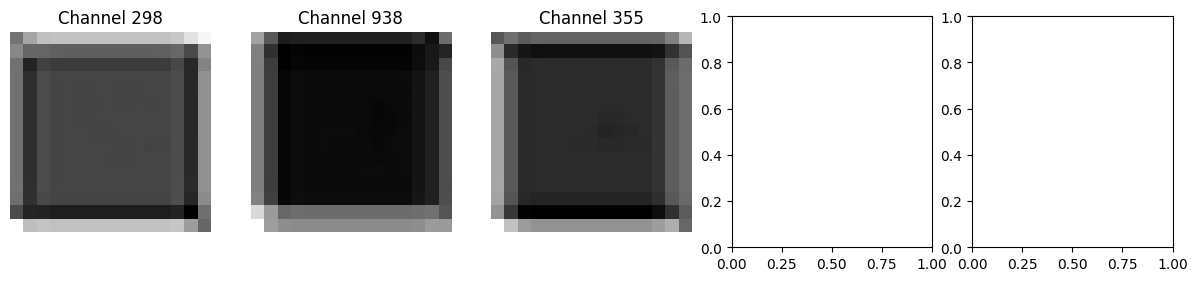

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(top_indices[:5]):
    axes[i].imshow(bottleneck[idx], cmap='gray')
    axes[i].set_title(f"Channel {idx}")
    axes[i].axis('off')
plt.show()


In [30]:
def channel_entropy(channel):
    hist, _ = np.histogram(channel, bins=256, range=(channel.min(), channel.max()), density=True)
    hist += 1e-8
    return -np.sum(hist * np.log2(hist))

entropies = [channel_entropy(bottleneck[i]) for i in range(bottleneck.shape[0])]
print("Avg Entropy of Bottleneck Channels:", np.mean(entropies))


Avg Entropy of Bottleneck Channels: -1341644.6016146564


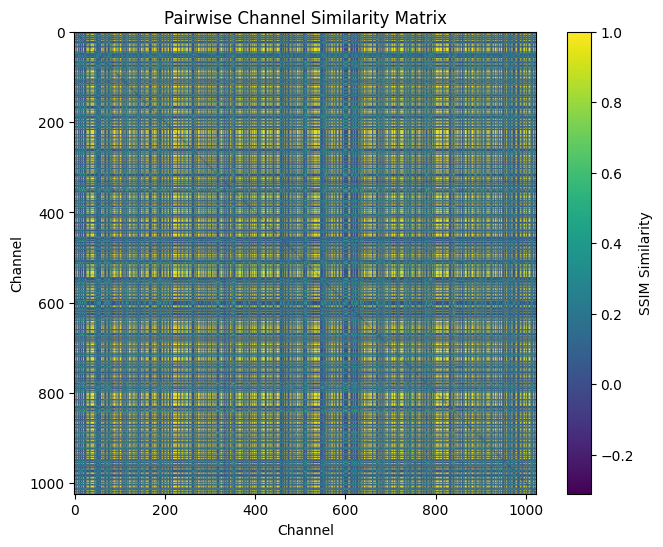

        channel_i  channel_j  similarity
245305        277        438         1.0
72782          73        805         1.0
72795          73        818         1.0
72790          73        813         1.0
72789          73        812         1.0


In [31]:
# ================== Cell: Pairwise Channel Similarity Matrix ==================
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def compute_channel_similarity_matrix(bottleneck, method="ssim"):
    if isinstance(bottleneck, torch.Tensor):
        bottleneck = bottleneck.detach().cpu().numpy()
    C, H, W = bottleneck.shape
    sim_matrix = np.zeros((C, C))
    pairwise_scores = []

    for i in range(C):
        for j in range(i + 1, C):
            ch_i = bottleneck[i]
            ch_j = bottleneck[j]

            if method == "ssim":
                s = ssim(ch_i, ch_j, data_range=ch_j.max() - ch_j.min() + 1e-8)
            elif method == "cosine":
                s = 1 - cosine(ch_i.flatten(), ch_j.flatten())
            elif method == "mse":
                s = mean_squared_error(ch_i.flatten(), ch_j.flatten())
            else:
                raise ValueError("Unknown method:", method)

            sim_matrix[i, j] = s
            sim_matrix[j, i] = s
            pairwise_scores.append({'channel_i': i, 'channel_j': j, 'similarity': s})

    sim_df = pd.DataFrame(pairwise_scores)
    sim_df.to_csv("pairwise_channel_similarity_0.csv", index=False)
    return sim_matrix, sim_df

# ----------- Usage -----------
similarity_method = "ssim"  # Options: 'ssim', 'cosine', 'mse'
sim_matrix, sim_df = compute_channel_similarity_matrix(bottleneck, method=similarity_method)

# Visualize similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(sim_matrix, cmap='viridis')
plt.colorbar(label=f"{similarity_method.upper()} Similarity")
plt.title("Pairwise Channel Similarity Matrix")
plt.xlabel("Channel")
plt.ylabel("Channel")
plt.show()

# Optional: preview top similar pairs
print(sim_df.sort_values("similarity", ascending=False).head())


/home/hiranmoy/.local/lib/python3.10/site-packages/scipy/spatial/distance.py:685: RuntimeWarning: invalid value encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


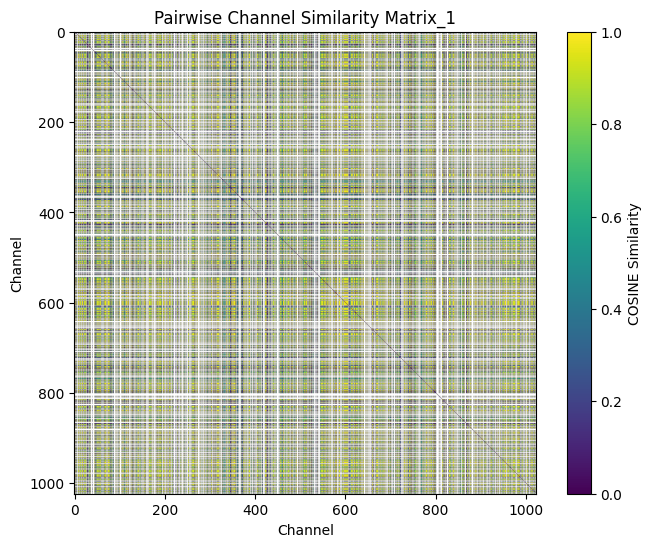

        channel_i  channel_j  similarity
201572        220        823         1.0
210013        231        497         1.0
385663        497        986         1.0
346261        427        819         1.0
210502        231        986         1.0


In [32]:
# ================== Cell: Pairwise Channel Similarity Matrix ==================
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def compute_channel_similarity_matrix(bottleneck, method="ssim"):
    if isinstance(bottleneck, torch.Tensor):
        bottleneck = bottleneck.detach().cpu().numpy()
    C, H, W = bottleneck.shape
    sim_matrix = np.zeros((C, C))
    pairwise_scores = []

    for i in range(C):
        for j in range(i + 1, C):
            ch_i = bottleneck[i]
            ch_j = bottleneck[j]

            if method == "ssim":
                s = ssim(ch_i, ch_j, data_range=ch_j.max() - ch_j.min() + 1e-8)
            elif method == "cosine":
                s = 1 - cosine(ch_i.flatten(), ch_j.flatten())
            elif method == "mse":
                s = mean_squared_error(ch_i.flatten(), ch_j.flatten())
            else:
                raise ValueError("Unknown method:", method)

            sim_matrix[i, j] = s
            sim_matrix[j, i] = s
            pairwise_scores.append({'channel_i': i, 'channel_j': j, 'similarity': s})

    sim_df = pd.DataFrame(pairwise_scores)
    sim_df.to_csv("pairwise_channel_similarity.csv", index=False)
    return sim_matrix, sim_df

# ----------- Usage -----------
similarity_method = "cosine"  # Options: 'ssim', 'cosine', 'mse'
sim_matrix, sim_df = compute_channel_similarity_matrix(bottleneck, method=similarity_method)

# Visualize similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(sim_matrix, cmap='viridis')
plt.colorbar(label=f"{similarity_method.upper()} Similarity")
plt.title("Pairwise Channel Similarity Matrix_1")
plt.xlabel("Channel")
plt.ylabel("Channel")
plt.show()

# Optional: preview top similar pairs
print(sim_df.sort_values("similarity", ascending=False).head())


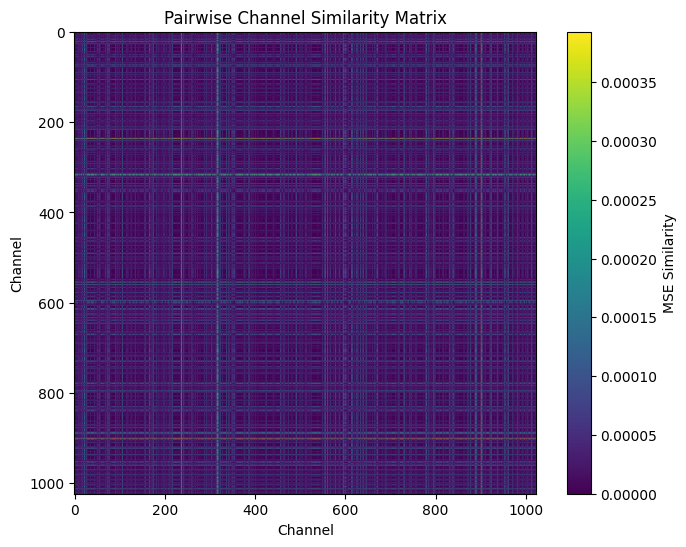

        channel_i  channel_j  similarity
326146        394        900    0.000393
448961        636        900    0.000393
374867        477        900    0.000393
161977        172        900    0.000393
383996        494        900    0.000393


In [33]:
# ================== Cell: Pairwise Channel Similarity Matrix ==================
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def compute_channel_similarity_matrix(bottleneck, method="ssim"):
    if isinstance(bottleneck, torch.Tensor):
        bottleneck = bottleneck.detach().cpu().numpy()
    C, H, W = bottleneck.shape
    sim_matrix = np.zeros((C, C))
    pairwise_scores = []

    for i in range(C):
        for j in range(i + 1, C):
            ch_i = bottleneck[i]
            ch_j = bottleneck[j]

            if method == "ssim":
                s = ssim(ch_i, ch_j, data_range=ch_j.max() - ch_j.min() + 1e-8)
            elif method == "cosine":
                s = 1 - cosine(ch_i.flatten(), ch_j.flatten())
            elif method == "mse":
                s = mean_squared_error(ch_i.flatten(), ch_j.flatten())
            else:
                raise ValueError("Unknown method:", method)

            sim_matrix[i, j] = s
            sim_matrix[j, i] = s
            pairwise_scores.append({'channel_i': i, 'channel_j': j, 'similarity': s})

    sim_df = pd.DataFrame(pairwise_scores)
    sim_df.to_csv("pairwise_channel_similarity_2.csv", index=False)
    return sim_matrix, sim_df

# ----------- Usage -----------
similarity_method = "mse"  # Options: 'ssim', 'cosine', 'mse'
sim_matrix, sim_df = compute_channel_similarity_matrix(bottleneck, method=similarity_method)

# Visualize similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(sim_matrix, cmap='viridis')
plt.colorbar(label=f"{similarity_method.upper()} Similarity")
plt.title("Pairwise Channel Similarity Matrix")
plt.xlabel("Channel")
plt.ylabel("Channel")
plt.show()

# Optional: preview top similar pairs
print(sim_df.sort_values("similarity", ascending=False).head())


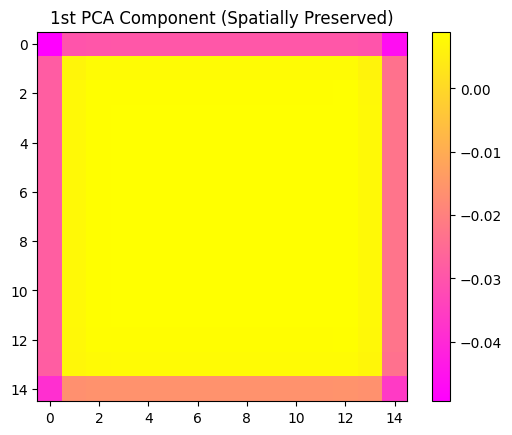

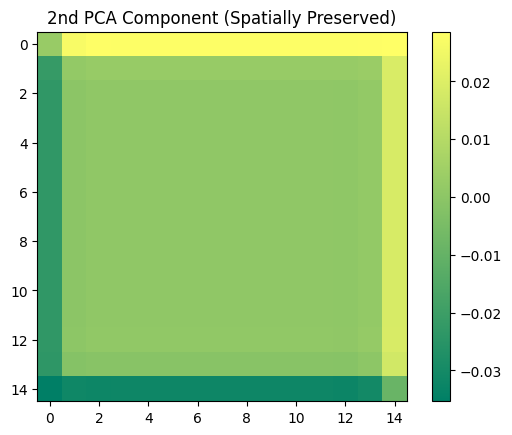

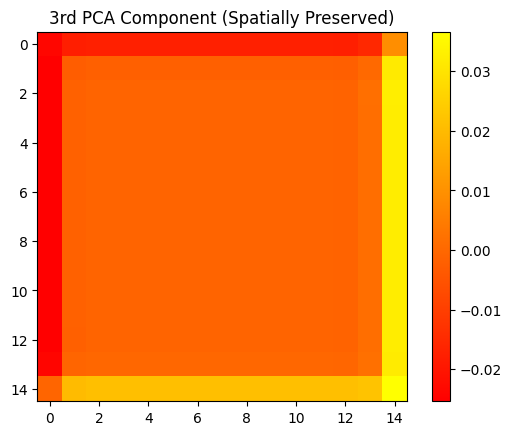

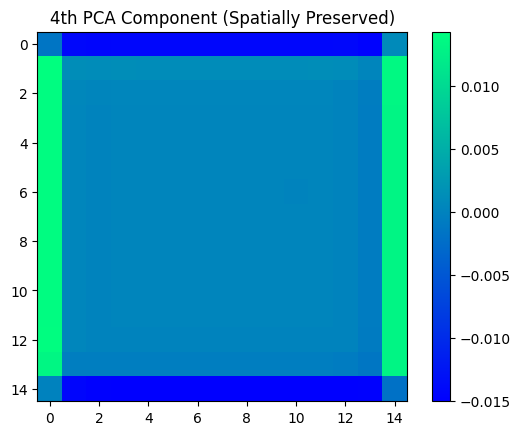

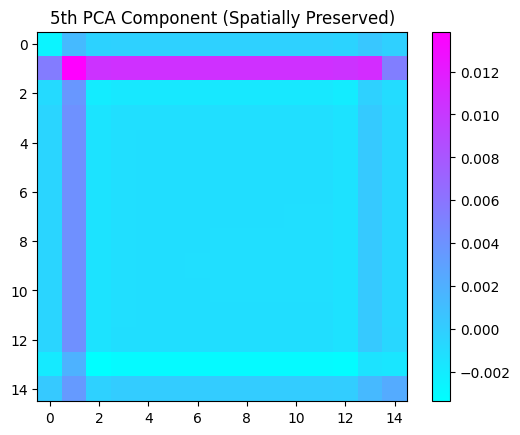

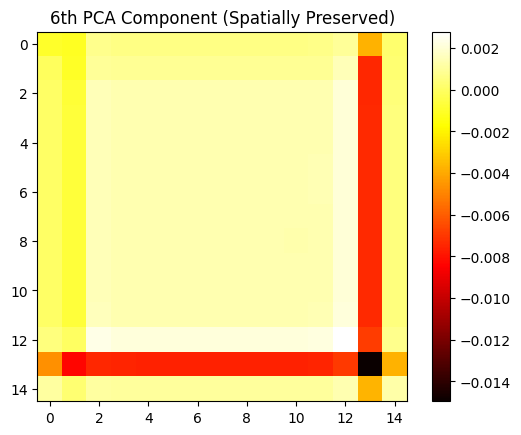

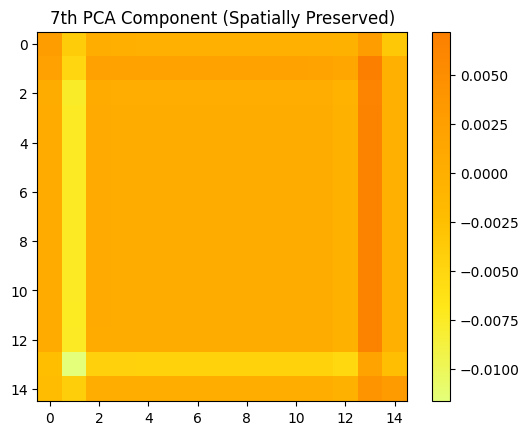

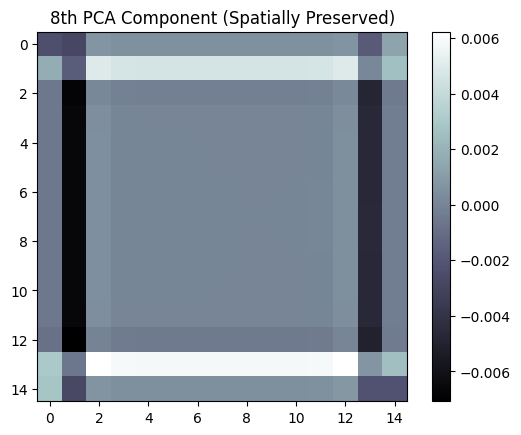

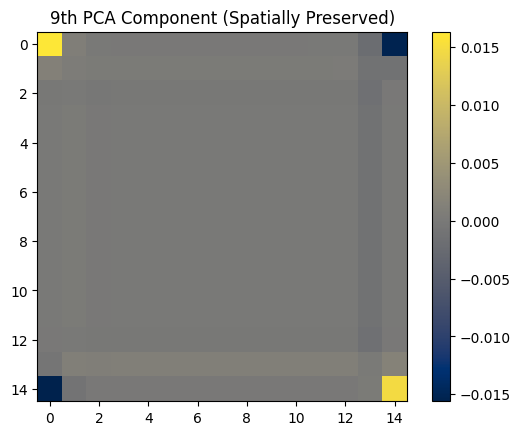

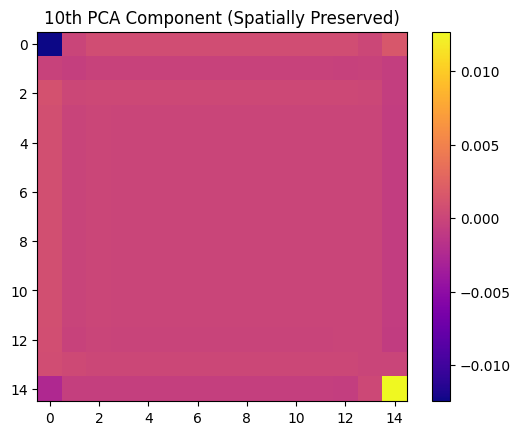

In [39]:
# Shape: (C, H, W) → transpose to (H*W, C) for PCA across channels
from sklearn.decomposition import PCA
n = 10
def spatially_preserving_pca(bottleneck, out_channels=n):
    C, H, W = bottleneck.shape
    reshaped = bottleneck.transpose(1, 2, 0).reshape(-1, C)  # shape: (H*W, C)
    
    pca = PCA(n_components=out_channels)
    reduced = pca.fit_transform(reshaped)  # shape: (H*W, out_channels)

    out = reduced.reshape(H, W, out_channels).transpose(2, 0, 1)  # (C', H, W)
    return out, pca

# Example use:
reduced_maps, pca_model = spatially_preserving_pca(bottleneck, out_channels=n)

# Visualize first component
import matplotlib.pyplot as plt
plt.imshow(reduced_maps[0], cmap='spring')
plt.title("1st PCA Component (Spatially Preserved)")
plt.colorbar()
plt.show()

# Visualize second component
import matplotlib.pyplot as plt
plt.imshow(reduced_maps[1], cmap='summer')
plt.title("2nd PCA Component (Spatially Preserved)")
plt.colorbar()
plt.show()
# Visualize third component
import matplotlib.pyplot as plt
plt.imshow(reduced_maps[2], cmap='autumn')
plt.title("3rd PCA Component (Spatially Preserved)")
plt.colorbar()
plt.show()
# Visualize fourth component
import matplotlib.pyplot as plt
plt.imshow(reduced_maps[3], cmap='winter')
plt.title("4th PCA Component (Spatially Preserved)")
plt.colorbar()
plt.show()


# Visualize fifth component
plt.imshow(reduced_maps[4], cmap='cool')
plt.title("5th PCA Component (Spatially Preserved)")
plt.colorbar()
plt.show()

# Visualize sixth component
plt.imshow(reduced_maps[5], cmap='hot')
plt.title("6th PCA Component (Spatially Preserved)")
plt.colorbar()
plt.show()

# Visualize seventh component
plt.imshow(reduced_maps[6], cmap='Wistia')
plt.title("7th PCA Component (Spatially Preserved)")
plt.colorbar()
plt.show()

# Visualize eighth component
plt.imshow(reduced_maps[7], cmap='bone')
plt.title("8th PCA Component (Spatially Preserved)")
plt.colorbar()
plt.show()

# Visualize ninth component
plt.imshow(reduced_maps[8], cmap='cividis')
plt.title("9th PCA Component (Spatially Preserved)")
plt.colorbar()
plt.show()

# Visualize tenth component
plt.imshow(reduced_maps[9], cmap='plasma')
plt.title("10th PCA Component (Spatially Preserved)")
plt.colorbar()
plt.show()

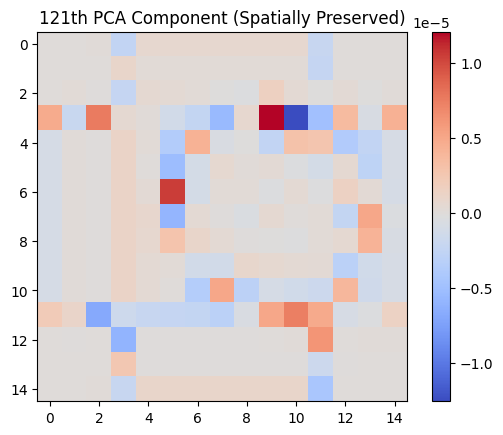

In [59]:
n = 121
reduced_maps, pca_model = spatially_preserving_pca(bottleneck, out_channels=n)
# Visualize nth component
plt.imshow(reduced_maps[n-1], cmap='coolwarm')
plt.title(f"{n}th PCA Component (Spatially Preserved)")
plt.colorbar()
plt.show()